In [2]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [1]:
import uuid
import itertools
import pickle
import zipfile
import os
import math
import matplotlib.pyplot as plt
import json
import datetime
import numpy as np

qbt_lifetime_array: ['1.00e-02', '1.51e-02', '2.28e-02', '3.43e-02', '5.18e-02', '7.81e-02', '1.18e-01', '1.78e-01', '2.68e-01', '4.05e-01', '6.11e-01', '9.21e-01', '1.39e+00', '2.10e+00', '3.16e+00']
p_p_array: [2.00000000e-02 1.32574063e-02 8.78794112e-03 5.82526531e-03
 3.86139546e-03 2.55960443e-03 1.69668580e-03 1.12468265e-03
 7.45518744e-04 4.94182246e-04 3.27578741e-04 2.17142224e-04
 1.43937135e-04 9.54116539e-05 6.32455532e-05]
decay_lifetime_array: ['2.00e-03', '2.84e-03', '4.05e-03', '5.77e-03', '8.23e-03', '1.17e-02', '1.67e-02', '2.38e-02', '3.39e-02', '4.84e-02', '6.89e-02', '9.82e-02', '1.40e-01', '2.00e-01']
p_e_array: [0.10023745 0.070337   0.04935574 0.03463311 0.02430219 0.01705294
 0.01196611 0.00839667 0.00589197 0.00413442 0.00290114 0.00203574
 0.00142849 0.00100237]


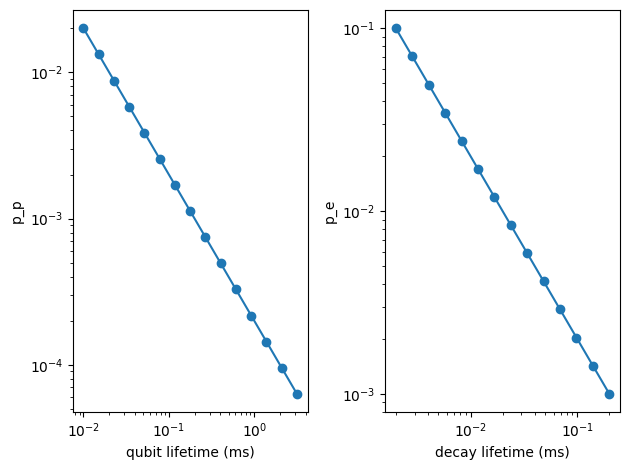

In [2]:
gate_time = 200*1e-6 # ms
qbt_lifetime_array = 10 ** np.linspace(-2,0.5,15) # ms
formatted_floats = [f"{num:.2e}" for num in qbt_lifetime_array]
print(f"qbt_lifetime_array: {formatted_floats}")

p_p_array = gate_time / qbt_lifetime_array
print(f"p_p_array: {p_p_array}")

fig, axes = plt.subplots(1,2)
axes[0].plot(qbt_lifetime_array,p_p_array,marker = 'o')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('qubit lifetime (ms)')
axes[0].set_ylabel('p_p')


decay_lifetime_array = 10 ** np.linspace(-2.7,-0.7,14)# ms
formatted_floats = [f"{num:.2e}" for num in decay_lifetime_array]
print(f"decay_lifetime_array: {formatted_floats}")

p_e_array = gate_time / decay_lifetime_array
print(f"p_e_array: {p_e_array}")

axes[1].plot(decay_lifetime_array,p_e_array,marker = 'o')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('decay lifetime (ms)')
axes[1].set_ylabel('p_e')


plt.tight_layout()

p_e_list = list(p_e_array)
p_z_shift_list = [0.0]
p_m_list = [0.0]
p_p_list = list(p_p_array)


In [6]:
import os
import json
import pandas as pd

json_list = []
directory = "erasure_decode_result_v2"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

directory = "erasure_decode_result_v2_additional_shots"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)

df = pd.DataFrame(json_list)


In [7]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'shots': 'sum',
    'new_circ': 'sum',
}

df_grouped = df.groupby(['p_e', 'p_z_shift','p_p','p_m','d']).agg(agg_rules).reset_index()
df_grouped['p_logi_era'] = df_grouped['new_circ'] / df_grouped['shots']
# df_grouped['p_logi_normal'] = df_grouped['normal'] / df_grouped['shots']


In [11]:
def compute_binary_confidence_interval(num_positive, n_samples, confidence_level=0.95):
    p_hat = num_positive / n_samples  # Estimated probability
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / n_samples)
    z = 1.96  # For a 95% confidence level
    margin_of_error = z * standard_error
    lower_bound = p_hat - margin_of_error
    upper_bound = p_hat + margin_of_error
    lower_bound = max(0,lower_bound)
    return lower_bound, upper_bound


In [12]:
# def plot_logi_vs_intrin(p_e,p_m, p_z_shift):
#     df = df_grouped
#     filtered_df = df.loc[(df['p_e'] == p_e) &
#                          (df['p_m'] == p_m) &
#                          (df['p_z_shift'] == p_z_shift)]

#     group_by_columns = ['d']        

#     for _, group in filtered_df.groupby(group_by_columns):
#         distance = group.iloc[0]['d']
#         x_values = group['p_p']
#         y_values = group['p_logi_era']

#         x_y_values = zip(x_values, y_values)
#         sorted_xy_values = sorted(x_y_values, key=lambda v: v[0])
#         sorted_x, sorted_y = zip(*sorted_xy_values)
#         color = unsaturated_colors['blue'].get(distance, 'blue')
#         plt.plot(sorted_x, sorted_y, color=color, label=f'd_{distance}_conditional_prob_decoding')
        
#         m = group['new_circ']
#         n = group['shots']
#         m_n_x_values = zip(m, n,x_values)
#         sorted_mn_values = sorted(m_n_x_values, key=lambda v: v[-1])
#         sorted_m, sorted_n,sorted_x = zip(*sorted_mn_values)
#         num_positive = sorted_m
#         n_samples = sorted_n
#         lower_bound, upper_bound = zip(*[compute_binary_confidence_interval(num, n) for num, n in zip(num_positive, n_samples)])
#         plt.fill_between(sorted_x, lower_bound, upper_bound, color=color, alpha=0.3)

#     # Set log scales for both x and y axes
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
#     # Set plot labels and legend
#     plt.title(f'leakage{p_e},p_z from shift{p_z_shift}')
#     plt.xlabel('p_intrin')
#     plt.ylabel('Per shot logical error')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()




# def make_logi_vs_intrin_widget():
#     interactive_plot = interactive(plot_logi_vs_intrin,
#                 p_e = p_e_list,
#                 p_m = p_m_list,
#                 p_z_shift = p_z_shift_list)
#     return interactive_plot


# make_logi_vs_intrin_widget()

In [13]:
import numpy as np

print(f"num p_e {len(p_e_list)}, num p_p {len(p_p_list)}")
distances = [3,5,7,9]
slope_array = []
for p_e in p_e_list:
    slope_array.append([])
    for p_p in p_p_list:
        p_log = []
        for d in distances:
            p_log.append(
                df_grouped.loc[(df_grouped['d'] == d) &
                        (df_grouped['p_e'] == p_e) &
                        (df_grouped['p_p'] == p_p) &
                        (df_grouped['p_m'] == p_m_list[-1]) &
                        (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]
            )

        slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)
        formatted_floats = [f"{num:.2e}" for num in p_log]
        # print(f"p_log: {formatted_floats}, base = {slope}")
        slope_array[-1].append(slope)
    
slope_array = np.array(slope_array)

num p_e 14, num p_p 15


/var/folders/9k/z8bpg3hj3d9841ggs75xmwxw0000gn/T/ipykernel_95410/126973211.py:19: RuntimeWarning: divide by zero encountered in log
  slope, intercept = np.polyfit(x=distances, y=np.log(p_log), deg = 1)


In [14]:
def get_p_log_at_distance(distances_considerd,p_e_idx, p_p_idx):
    assert p_e_idx < len(p_e_list)
    assert p_p_idx < len(p_p_list)
    # p_log_list = []
    p_log_used = []
    distances_used = []
    # errors = [[],[]]
    for d in distances:
        p_log = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]

        # m = df_grouped.loc[(df_grouped['d'] == d) &
        #             (df_grouped['p_e'] == p_e_list[p_e_idx]) &
        #             (df_grouped['p_p'] == p_p_list[p_p_idx]) &
        #             (df_grouped['p_m'] == p_m_list[-1]) &
        #             (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'new_circ'].iloc[0]
        
        # n = df_grouped.loc[(df_grouped['d'] == d) &
        #             (df_grouped['p_e'] == p_e_list[p_e_idx]) &
        #             (df_grouped['p_p'] == p_p_list[p_p_idx]) &
        #             (df_grouped['p_m'] == p_m_list[-1]) &
        #             (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'shots'].iloc[0]

        # lower_bound, upper_bound = compute_binary_confidence_interval(m, n)
        # errors[0].append(p_log - lower_bound)
        # errors[1].append(upper_bound - p_log)
        # p_log_list.append(p_log)
        
        if p_log > 0 :
            p_log_used.append(p_log)
            distances_used.append(d)

    # plt.errorbar(distances, p_log_list, yerr=errors, fmt='o', capsize=5, capthick=1)

    # plt.title(f"""p_e: {p_e_list[p_e_idx]:.1e}, \n p_p: {p_p_list[p_p_idx]:.1e}""")
    # plt.plot(distances,p_log_list, linestyle='', marker='o')
    # plt.yscale('log')
    # plt.xticks([3,5,7,9,11,13])

    if len(distances_used)>=2:
        slope, intercept = np.polyfit(x=distances_used, y=np.log10(p_log_used), deg = 1)
        # distances_considerd = np.array([3,5,7,9,11,13])
        # P_log_predicted = distances_considerd*slope + intercept
        P_log_predicted = distances_considerd*slope + intercept
        P_log_predicted = 10**P_log_predicted
        # plt.plot(distances_considerd,P_log_predicted)
        return P_log_predicted
    else:
        return np.nan


for d in list(range(3,50))[::2]:
    temp  = []
    for i,p_e in enumerate(p_e_list):
        temp.append([])
        for j,p_p in enumerate(p_p_list):
            temp[-1].append(get_p_log_at_distance(d,i, j))
    temp = np.array(temp)
    globals()[f"p_log_d{d}_array"] = temp


In [15]:
def plot_scaling(ax, p_e_idx, p_p_idx, color,alpha = 0.5):
    assert p_e_idx < len(p_e_list)
    assert p_p_idx < len(p_p_list)
    p_log_list = []
    p_log_used = []
    distances_used = []
    errors = [[],[]]
    for d in distances:
        p_log = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'p_logi_era'].iloc[0]

        m = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'new_circ'].iloc[0]
        
        n = df_grouped.loc[(df_grouped['d'] == d) &
                    (df_grouped['p_e'] == p_e_list[p_e_idx]) &
                    (df_grouped['p_p'] == p_p_list[p_p_idx]) &
                    (df_grouped['p_m'] == p_m_list[-1]) &
                    (df_grouped['p_z_shift'] == p_z_shift_list[0]), 'shots'].iloc[0]

        lower_bound, upper_bound = compute_binary_confidence_interval(m, n)
        errors[0].append(p_log - lower_bound)
        errors[1].append(upper_bound - p_log)
        p_log_list.append(p_log)
        
        if p_log > 0 :
            p_log_used.append(p_log)
            distances_used.append(d)

    ax.errorbar(distances, p_log_list, yerr=errors, fmt='o', capsize=5, capthick=1,color=color,alpha=alpha)

    # plt.title(f"""p_e: {p_e_list[p_e_idx]:.1e}, \n p_p: {p_p_list[p_p_idx]:.1e}""")
    ax.plot(distances,p_log_list, linestyle='', marker='o',color=color,alpha=alpha)

    if len(distances_used)>=2:
        slope, intercept = np.polyfit(x=distances_used, y=np.log10(p_log_used), deg = 1)
        distances_considerd = np.array([3,5,7,9,11,13])
        P_log_predicted = distances_considerd*slope + intercept
        P_log_predicted = 10**P_log_predicted
        ax.plot(distances_considerd,P_log_predicted,color=color,alpha=alpha)

# fig, axes = plt.subplots(1,3,figsize = (30,14))

# for p_e_idx in range(len(p_e_list)):
#     for p_p_idx in range(len(p_p_list)):
# # for p_e_idx in [9]:
# #     for p_p_idx in range(len(p_p_list)):
#         if p_log_d13_array[p_e_idx, p_p_idx] < 1e-9:
#             plot_scaling(axes[2], p_e_idx, p_p_idx,color='black')
#         elif p_log_d11_array[p_e_idx, p_p_idx] < 1e-6:
#             plot_scaling(axes[1], p_e_idx, p_p_idx,color='#d5373d')
#         elif p_log_d7_array[p_e_idx, p_p_idx] < 1e-3:
#             plot_scaling(axes[0], p_e_idx, p_p_idx,color='#4999c3')

# for ax in axes:
#     ax.set_yscale('log')
#     ax.set_xticks([3,5,7,9,11,13])
#     ax.set_ylim(1e-6,1e-2)

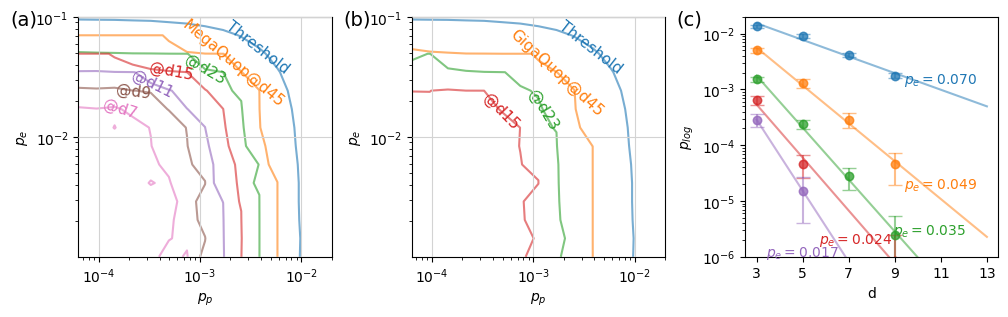

In [73]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assuming p_p_list, p_e_list, slope_array, p_log_dX_array are predefined
colors = [value for (key,value) in  mcolors.TABLEAU_COLORS.items()]

fig = plt.figure(figsize=(10, 3)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0+0.07, right=1/3-0.01,bottom=0.15,top = 0.95)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=1/3+0.07, right=2/3-0.01,bottom=0.15,top = 0.95)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=2/3+0.07, right=3/3-0.01,bottom=0.15,top = 0.95)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])



temp_x = np.arange(len(p_p_list))
temp_y = np.arange(len(p_e_list))
X, Y = np.meshgrid(temp_x, temp_y)

for ax, level,logical_error_str,d_list, in zip([ ax0,ax1],
                     [1e-6,1e-9],
                     ['MegaQuop','GigaQuop'],
                     [[7, 9, 11, 15, 23, 45],
                      [ 15,23, 45]],
                     ):

    contour = ax.contour(X, Y, slope_array, levels=[0], colors=colors[0], alpha=0.6)
    labels = ax.clabel(contour, fmt={0: 'Threshold'}, inline=False, fontsize=11, manual=[(5, 3)])
    labels[0].set_color(colors[0])

    for d, label_loc, color in zip(d_list[::-1],
                                [(11.7, 5), (11, 6), (11, 6.5), (9, 5), (9, 6), (6, 3)][::-1],
                                colors[1:]):
        contour = ax.contour(X, Y, globals()[f"p_log_d{d}_array"], levels=[level], colors=color, alpha=0.6)
        if d == d_list[-1]:
            string = rf'{logical_error_str}@d{d}'
        else:
            string = rf'@d{d}'
        labels = ax.clabel(contour, fmt={level: string}, inline=False, fontsize=11, manual=[label_loc])
        labels[0].set_color(color)

    ax.set_xticks(np.arange(len(p_p_list)))
    ax.set_yticks(np.arange(len(p_e_list)))
    # xtick_labels = [f'{val:.5f}' for val in p_p_list[::]]
    # ax.set_xticklabels(xtick_labels, rotation=-45)
    # ax.set_yticklabels([f'{val:.3f}' for val in p_e_list])

    xmin = p_p_list[-1]
    xmax = p_p_list[0]
    ymin = p_e_list[-1]
    ymax = p_e_list[0]

    
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    # Create a new axis on top of the original one
    pos = ax.get_position()
    ax_twin = fig.add_axes(pos, frameon=False)
    ax_twin.set_xlim(xmin, xmax)
    ax_twin.set_ylim(ymin, ymax)
    ax_twin.set_xscale('log')
    ax_twin.set_yscale('log')


    ax_twin.set_xlabel(r'$p_p$')
    ax_twin.set_ylabel(r'$p_e$')
    ax_twin.grid(color='lightgrey')
    ax.invert_xaxis()
    ax.invert_yaxis()


p_p_idx = -2
for p_e_idx, color, (x, y) in zip([1, 2, 3, 4, 5],
                                  mcolors.TABLEAU_COLORS,
                                  [(11, 1.5e-3), (11, 2e-5),  (10.5, 3e-6), (7.3, 2e-6), (5, 1.17e-6)]):
    plot_scaling(ax2, p_e_idx, p_p_idx, color=color)
    ax2.text(x, y, rf"$p_e = ${p_e_list[p_e_idx]:.3f}", color=color, ha='center', va='center')

ax2.set_yscale('log')
ax2.set_xticks([3, 5, 7, 9, 11, 13])
ax2.set_ylim(1e-6, 2e-2)
ax2.set_ylabel(r'$p_{log}$')
ax2.set_xlabel('d')

ax0.text(-0.27, 1.03, '(a)', transform=ax0.transAxes, fontsize=14,  va='top')
ax1.text(-0.27, 1.03, '(b)', transform=ax1.transAxes, fontsize=14,  va='top')
ax2.text(-0.27, 1.03, '(c)', transform=ax2.transAxes, fontsize=14,  va='top')

# plt.tight_layout()
fig.savefig('combined_plot.pdf')


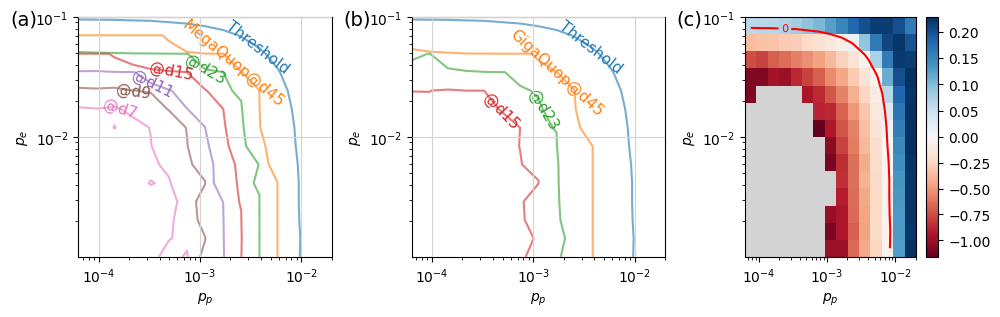

In [25]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Assuming p_p_list, p_e_list, slope_array, p_log_dX_array are predefined
colors = [value for (key,value) in  mcolors.TABLEAU_COLORS.items()]

fig = plt.figure(figsize=(10, 3)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0+0.07, right=1/3-0.01,bottom=0.15,top = 0.95)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=1/3+0.07, right=2/3-0.01,bottom=0.15,top = 0.95)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=2/3+0.07, right=3/3-0.05,bottom=0.15,top = 0.95)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])



temp_x = np.arange(len(p_p_list))
temp_y = np.arange(len(p_e_list))
X, Y = np.meshgrid(temp_x, temp_y)

for ax, level,logical_error_str,d_list, in zip([ ax0,ax1],
                     [1e-6,1e-9],
                     ['MegaQuop','GigaQuop'],
                     [[7, 9, 11, 15, 23, 45],
                      [ 15,23, 45]],
                     ):

    contour = ax.contour(X, Y, slope_array, levels=[0], colors=colors[0], alpha=0.6)
    labels = ax.clabel(contour, fmt={0: 'Threshold'}, inline=False, fontsize=11, manual=[(5, 3)])
    labels[0].set_color(colors[0])

    for d, label_loc, color in zip(d_list[::-1],
                                [(11.7, 5), (11, 6), (11, 6.5), (9, 5), (9, 6), (6, 3)][::-1],
                                colors[1:]):
        contour = ax.contour(X, Y, globals()[f"p_log_d{d}_array"], levels=[level], colors=color, alpha=0.6)
        if d == d_list[-1]:
            string = rf'{logical_error_str}@d{d}'
        else:
            string = rf'@d{d}'
        labels = ax.clabel(contour, fmt={level: string}, inline=False, fontsize=11, manual=[label_loc])
        labels[0].set_color(color)

    ax.set_xticks(np.arange(len(p_p_list)))
    ax.set_yticks(np.arange(len(p_e_list)))
    # xtick_labels = [f'{val:.5f}' for val in p_p_list[::]]
    # ax.set_xticklabels(xtick_labels, rotation=-45)
    # ax.set_yticklabels([f'{val:.3f}' for val in p_e_list])

    xmin = p_p_list[-1]
    xmax = p_p_list[0]
    ymin = p_e_list[-1]
    ymax = p_e_list[0]

    
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    # Create a new axis on top of the original one
    pos = ax.get_position()
    ax_twin = fig.add_axes(pos, frameon=False)
    ax_twin.set_xlim(xmin, xmax)
    ax_twin.set_ylim(ymin, ymax)
    ax_twin.set_xscale('log')
    ax_twin.set_yscale('log')


    ax_twin.set_xlabel(r'$p_p$')
    ax_twin.set_ylabel(r'$p_e$')
    ax_twin.grid(color='lightgrey')
    ax.invert_xaxis()
    ax.invert_yaxis()



contour = ax2.contour(X, Y, slope_array, levels=[0], colors='red')
ax2.clabel(contour, inline=True, fontsize=8)

cmap = plt.get_cmap('RdBu')
cmap = cmap(np.arange(cmap.N))
cmap[:, -1] = np.linspace(1, 1, cmap.shape[0])  # Set alpha to 1 for all colors
cmap = mcolors.ListedColormap(cmap)
cmap.set_bad(color='lightgray')  # Set color for NaN values

cax = ax2.imshow(slope_array, cmap= cmap, norm= mcolors.TwoSlopeNorm(vmin = np.nanmin(slope_array),vcenter = 0,vmax = np.nanmax(slope_array)),
        aspect='auto',origin='lower')
cbar = fig.colorbar(cax, ax=ax2)
cbar.set_ticks([-1,-0.75,-0.5,-0.25,0,0.05,0.1,0.15,0.2])
ax2.invert_xaxis()
ax2.invert_yaxis()

ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
# Create a new axis on top of the original one
pos = ax2.get_position()
ax_twin = fig.add_axes(pos, frameon=False)
ax_twin.set_xlim(xmin, xmax)
ax_twin.set_ylim(ymin, ymax)
ax_twin.set_xscale('log')
ax_twin.set_yscale('log')


ax_twin.set_xlabel(r'$p_p$')
ax_twin.set_ylabel(r'$p_e$')


ax0.text(-0.27, 1.03, '(a)', transform=ax0.transAxes, fontsize=14,  va='top')
ax1.text(-0.27, 1.03, '(b)', transform=ax1.transAxes, fontsize=14,  va='top')
ax2.text(-0.40, 1.03, '(c)', transform=ax2.transAxes, fontsize=14,  va='top')

# plt.tight_layout()
fig.savefig('combined_plot_heatmap.pdf')


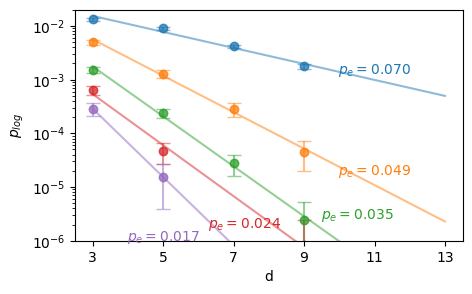

In [28]:
fig,ax=plt.subplots(figsize=(5,3))
p_p_idx = -2
for p_e_idx, color, (x, y) in zip([1, 2, 3, 4, 5],
                                  mcolors.TABLEAU_COLORS,
                                  [(11, 1.5e-3), (11, 2e-5),  (10.5, 3e-6), (7.3, 2e-6), (5, 1.17e-6)]):
    plot_scaling(ax, p_e_idx, p_p_idx, color=color)
    ax.text(x, y, rf"$p_e = ${p_e_list[p_e_idx]:.3f}", color=color, ha='center', va='center')

ax.set_yscale('log')
ax.set_xticks([3, 5, 7, 9, 11, 13])
ax.set_ylim(1e-6, 2e-2)
ax.set_ylabel(r'$p_{log}$')
ax.set_xlabel('d')
fig.savefig('fit.pdf')
